In [4]:
import os
import glob
import time

import numpy as np
import cv2
import pickle

from mvt.utils import draw_motion_vectors, draw_boxes, draw_box_ids, draw_shifts
from mvt.trackerlib import normalize_vectors, get_nonzero_vectors

import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()

### Load data

In [6]:
frames = []
frame_types = []
det_boxes = []
gt_boxes = []
gt_ids = []
motion_vectors = []
motion_vector_subsets = []
box_ids = []

dev_outputs = sorted(glob.glob("dev_output/*.pkl"))
for frame_idx, dev_output in enumerate(dev_outputs):
    data = pickle.load(open(dev_output, "rb"))

    frame = data["frame"]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_type = data["frame_type"]
    det_box = data["det_boxes"]
    gt_box = data["gt_boxes"]
    gt_id = data["gt_ids"]
    motion_vector = data["motion_vectors"]
    tracker_debug_data = data["tracker_debug_data"]
    
    frames.append(frame)
    frame_types.append(frame_type)
    det_boxes.append(det_box)
    gt_boxes.append(gt_box)
    gt_ids.append(gt_id)
    motion_vectors.append(motion_vector)
    
    box_ids.append(tracker_debug_data["box_ids"])
    
    if tracker_debug_data["type"] == "predict":
        motion_vector_subsets.append(tracker_debug_data["motion_vector_subsets"])
    else:
        motion_vector_subsets.append(None)

In [7]:
for frame_idx in range(len(motion_vectors)):
    motion_vectors[frame_idx] = normalize_vectors(motion_vectors[frame_idx])

### Data Preprocessing

#### Interpolate motion vectors on 2D grid with fixed 16 x 16 spacing

In [107]:
from scipy.interpolate import griddata
import time

frame_idx = 73
mvs_x = motion_vectors[frame_idx][:, 5]
mvs_y = motion_vectors[frame_idx][:, 6]
mvs_x_motion = motion_vectors[frame_idx][:, 7] / motion_vectors[frame_idx][:, 9]
mvs_y_motion = motion_vectors[frame_idx][:, 8] / motion_vectors[frame_idx][:, 9]

# takes 5.72 ms (average of 1000 runs)
xi = np.arange(8, 1920+1, 16)
yi = np.arange(8, 1080+1, 16)
mvs_x_motion_interp = griddata((mvs_x, mvs_y), mvs_x_motion, (xi[None, :], yi[:, None]), method='nearest')
mvs_y_motion_interp = griddata((mvs_x, mvs_y), mvs_y_motion, (xi[None, :], yi[:, None]), method='nearest')

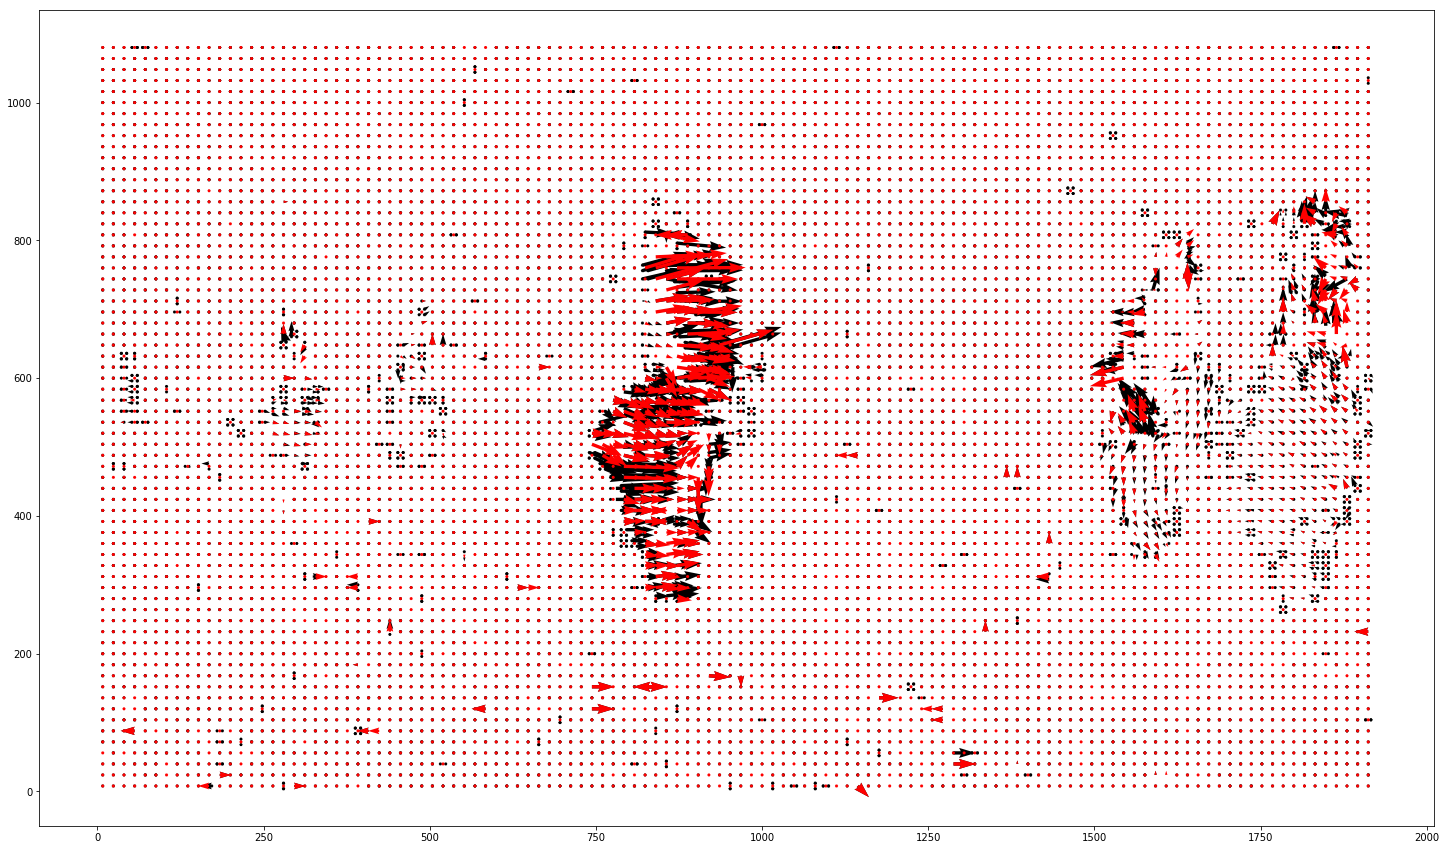

In [109]:
f, ax = plt.subplots(figsize=(25,15))
ax.quiver(mvs_x, mvs_y, mvs_x_motion, mvs_y_motion, scale=1000)
ax.quiver(xi, yi, mvs_x_motion_interp, mvs_y_motion_interp, scale=1000, color='r')

### Propagation Network

In [5]:
import torch
import torchvision

In [18]:
class Model(nn.Model):
    pass

NameError: name 'nn' is not defined

### Training loop

In [16]:
epochs = 2
steps = len(motion_vectors)

for epoch in range(epochs):
    for step in range(1, steps):
        
        mvs = motion_vectors[step]
        mvs_p = motion_vectors[step-1]
        
        if not mvs.size:
            continue
        #print(mvs[0,0])

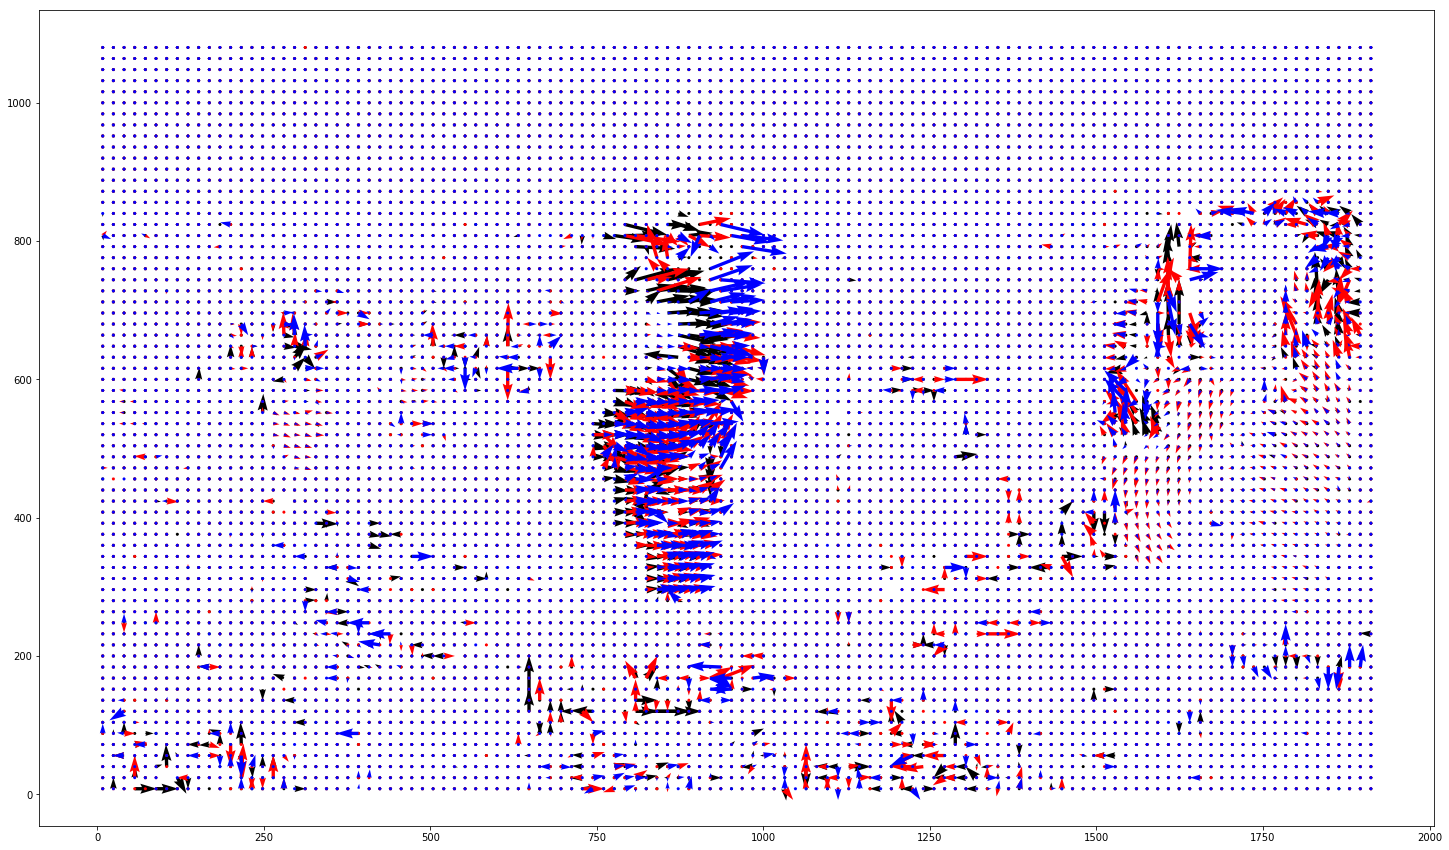

In [209]:
frame_idx = 73
f, ax = plt.subplots(figsize=(25,15))
x = motion_vectors[frame_idx][:, 5]
y = motion_vectors[frame_idx][:, 6]
u = motion_vectors[frame_idx][:, 7] / motion_vectors[frame_idx][:, 9]
v = motion_vectors[frame_idx][:, 8] / motion_vectors[frame_idx][:, 9]
ax.quiver(x, y, u, v, scale=1000)

x = motion_vectors[frame_idx+1][:, 5]
y = motion_vectors[frame_idx+1][:, 6]
u = motion_vectors[frame_idx+1][:, 7] / motion_vectors[frame_idx+1][:, 9]
v = motion_vectors[frame_idx+1][:, 8] / motion_vectors[frame_idx+1][:, 9]
ax.quiver(x, y, u, v, scale=1000, color='r')

x = motion_vectors[frame_idx+2][:, 5]
y = motion_vectors[frame_idx+2][:, 6]
u = motion_vectors[frame_idx+2][:, 7] / motion_vectors[frame_idx+2][:, 9]
v = motion_vectors[frame_idx+2][:, 8] / motion_vectors[frame_idx+2][:, 9]
ax.quiver(x, y, u, v, scale=1000, color='b')

### Equalize numbers of motion_vectors throughout frames

In [227]:
for mv in motion_vectors:
    
    last_len = 0
    len(mv)
    
    len(motion_vectors[2])

In [232]:
width = 1920
height = 1080
width / 16 * height / 16

8100.0

In [281]:
xv, yv = np.meshgrid(np.arange(8, 1920, 16), np.arange(8, 1080, 16), sparse=False, indexing='xy')

In [296]:
xv

array([[   8,   24,   40, ..., 1880, 1896, 1912],
       [   8,   24,   40, ..., 1880, 1896, 1912],
       [   8,   24,   40, ..., 1880, 1896, 1912],
       ...,
       [   8,   24,   40, ..., 1880, 1896, 1912],
       [   8,   24,   40, ..., 1880, 1896, 1912],
       [   8,   24,   40, ..., 1880, 1896, 1912]])

In [299]:
print(np.where(motion_vectors[0][:, 5] != xv))
print(np.where(motion_vectors[0][:, 6] != yv))

(array([0]),)
(array([0]),)


/home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.
/home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [292]:
motion_vectors[73][0:200, 5]

array([   8,   24,   40,   56,   72,   88,  104,  120,  136,  152,  168,
        184,  200,  216,  232,  248,  264,  280,  296,  312,  328,  344,
        360,  376,  408,  424,  440,  456,  472,  488,  504,  520,  536,
        552,  568,  584,  600,  616,  632,  648,  664,  680,  696,  712,
        728,  744,  760,  776,  792,  808,  824,  840,  888,  904,  920,
        936,  952,  968,  984, 1000, 1016, 1032, 1064, 1096, 1160, 1176,
       1192, 1208, 1224, 1240, 1256, 1272, 1288, 1304, 1320, 1336, 1352,
       1368, 1384, 1400, 1416, 1432, 1448, 1464, 1480, 1496, 1512, 1528,
       1544, 1560, 1576, 1592, 1608, 1624, 1640, 1656, 1672, 1688, 1704,
       1720, 1736, 1752, 1768, 1784, 1800, 1816, 1832, 1848, 1864, 1880,
       1896, 1912,    8,   24,   40,   56,   72,  120,  136,  152,  168,
        200,  216,  232,  248,  264,  296,  312,  328,  344,  360,  376,
        392,  424,  440,  456,  472,  488,  504,  520,  536,  552,  568,
        584,  600,  616,  632,  648,  664,  680,  6

In [277]:
np.arange(8, 1920, 16)

array([   8,   24,   40,   56,   72,   88,  104,  120,  136,  152,  168,
        184,  200,  216,  232,  248,  264,  280,  296,  312,  328,  344,
        360,  376,  392,  408,  424,  440,  456,  472,  488,  504,  520,
        536,  552,  568,  584,  600,  616,  632,  648,  664,  680,  696,
        712,  728,  744,  760,  776,  792,  808,  824,  840,  856,  872,
        888,  904,  920,  936,  952,  968,  984, 1000, 1016, 1032, 1048,
       1064, 1080, 1096, 1112, 1128, 1144, 1160, 1176, 1192, 1208, 1224,
       1240, 1256, 1272, 1288, 1304, 1320, 1336, 1352, 1368, 1384, 1400,
       1416, 1432, 1448, 1464, 1480, 1496, 1512, 1528, 1544, 1560, 1576,
       1592, 1608, 1624, 1640, 1656, 1672, 1688, 1704, 1720, 1736, 1752,
       1768, 1784, 1800, 1816, 1832, 1848, 1864, 1880, 1896, 1912])

In [210]:
def vector_matching_ratio(a, b):
    1 - (np.linalg.norm((a - b), axis=1)) / ()
    return 

vmr = vector_matching_ratio(motion_vectors[frame_idx][:, 7:9], motion_vectors[frame_idx-1][:, 7:9])

In [221]:
frame_idx = 74
len(np.linalg.norm((motion_vectors[frame_idx][:, 7:9] - motion_vectors[frame_idx-1][:, 7:9]), axis=1))

ValueError: operands could not be broadcast together with shapes (7829,2) (7875,2) 

In [104]:
pt = 8000
motion_vectors[frame_idx][pt:pt+100, :]

array([[ -1,  16,  16, 216, 600, 216, 600,   0,   0,   4],
       [ -1,  16,  16, 232, 600, 232, 600,   0,   0,   4],
       [ -1,  16,  16, 232, 600, 232, 600,   0,   0,   4],
       [ -1,  16,  16, 248, 600, 248, 600,   0,   0,   4],
       [ -1,  16,  16, 248, 600, 248, 600,   0,   0,   4],
       [ -1,  16,  16, 264, 600, 264, 600,   0,   0,   4],
       [ -1,  16,  16, 264, 600, 264, 600,   0,   0,   4],
       [ -1,  16,  16, 287, 600, 280, 600,  31,   0,   4],
       [ -1,  16,  16, 295, 600, 296, 600,   4,  -3,   4],
       [ -1,  16,  16, 296, 600, 296, 600,   0,  -3,   4],
       [ -1,  16,  16, 317, 600, 312, 600,  21,  -3,   4],
       [ -1,  16,  16, 328, 600, 328, 600,   0,   0,   4],
       [ -1,  16,  16, 344, 600, 344, 600,   0,   0,   4],
       [ -1,  16,  16, 360, 600, 360, 600,   0,   0,   4],
       [ -1,  16,  16, 360, 600, 360, 600,   0,   0,   4],
       [ -1,  16,  16, 376, 600, 376, 600,   0,   0,   4],
       [ -1,  16,  16, 376, 600, 376, 600,   0,   0,   4

In [154]:
frame_idx = 73

motion_vectors[frame_idx] = get_nonzero_vectors(motion_vectors[frame_idx])

mv = motion_vectors[frame_idx][:, 7:9]

In [155]:
mv

array([[ -1,  -1],
       [ -1,  -1],
       [-32,   0],
       ...,
       [  1,   0],
       [  0,   1],
       [ -1,   0]], dtype=int32)